<a href="https://colab.research.google.com/github/johncoogan53/XAI_HW4/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04

Description: This notebook will cover some interpretable methods for machine learning with the imodels python library

### John Coogan


We will use credit prediction data from openml.org: https://www.openml.org/search?type=data&sort=nr_of_likes&status=active&id=31

Open ML utilizes arff files which are new to me but appear to be regular data files with metadata on top.

### We will start by loading in the data and setting it into a train test split. Then we will train three of our imodels models on that data

In [29]:
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.tree import plot_tree
from imodels import RuleFitClassifier, FIGSClassifier, HSTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
data, meta = loadarff('/content/drive/MyDrive/MISC/dataset_31_credit-g.arff')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
df = pd.DataFrame(data)
df = df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x) #the contents are b'' or byte string notation. This decode line should get them to normal
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [31]:
# store feature names (all columns but class) as feat_names list of stings
feat_names = list(df.columns[:-1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

We will have to convert our object variables to categorical variables or we will have issues fitting the data. I am not sure if the original labels will be retained by the models so I will store them in a dictionary

In [5]:
# Convert 'class' to binary good = 1, bad = 0
df['class'] = df['class'].map({'good': 1, 'bad': 0})

#convert dtyp = object to categorical variables but make a dictionary to retain original values
categorical_columns = df.select_dtypes(include=['object']).columns

category_mappings = {}

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    category_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

category_mappings

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'checking_status': {'0<=X<200': 0, '<0': 1, '>=200': 2, 'no checking': 3},
 'credit_history': {'all paid': 0,
  'critical/other existing credit': 1,
  'delayed previously': 2,
  'existing paid': 3,
  'no credits/all paid': 4},
 'purpose': {'business': 0,
  'domestic appliance': 1,
  'education': 2,
  'furniture/equipment': 3,
  'new car': 4,
  'other': 5,
  'radio/tv': 6,
  'repairs': 7,
  'retraining': 8,
  'used car': 9},
 'savings_status': {'100<=X<500': 0,
  '500<=X<1000': 1,
  '<100': 2,
  '>=1000': 3,
  'no known savings': 4},
 'employment': {'1<=X<4': 0, '4<=X<7': 1, '<1': 2, '>=7': 3, 'unemployed': 4},
 'personal_status': {'female div/dep/mar': 0,
  'male div/sep': 1,
  'male mar/wid': 2,
  'male single': 3},
 'other_parties': {'co applicant': 0, 'guarantor': 1, 'none': 2},
 'property_magnitude': {'car': 0,
  'life insurance': 1,
  'no known property': 2,
  'real estate': 3},
 'other_payment_plans': {'bank': 0, 'none': 1, 'stores': 2},
 'housing': {'for free': 0, 'own': 1, 're

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1), df['class'], test_size=0.2, random_state=42)
print('Training data', X_train.shape, y_train.shape)
print('Testing data', X_test.shape, y_test.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training data (800, 20) (800,)
Testing data (200, 20) (200,)


### Now that we have the data loaded in, lets try and use RuleFit from imodels to predict the class.

In [7]:
rulefitClass = RuleFitClassifier(max_rules=10)
rulefitClass.fit(X_train, y_train)

preds = rulefitClass.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.715


> We can see that our accuracy here is 0.715 which is ok, but where the real value of these methods lies is in their interpretability:

Here lets see what the output looks like for Rulefit

In [8]:
rulefitClass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RuleFitClassifier(max_rules=10)

In [9]:
# we can also look at the demo for alternative representations:

rules = rulefitClass._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
display(rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rule,coef,support
12,age,0.003074,1.000000
20,duration <= 43.5 and credit_amount <= 7834.5,0.024895,0.876250
23,credit_history <= 3.5 and credit_amount <= 6365.0,0.074667,0.826250
21,duration <= 27.5 and credit_history <= 3.5,0.124397,0.751250
22,duration <= 26.5 and credit_history <= 3.5,0.006173,0.738750
25,age > 25.5 and housing > 0.5 and credit_history > 0.5,0.234661,0.680000
26,checking_status > 1.5 and employment <= 3.5,0.276233,0.447500
27,checking_status > 1.5 and credit_amount <= 7361.5,0.042804,0.430000
24,purpose > 4.5 and credit_amount <= 11307.0,0.018467,0.417500
28,checking_status > 1.5 and other_payment_plans > 0.5 and credit_history <= 3.5,0.416578,0.398750


This is a really neat output, we can see each rule, the coefficient added to the prediction and the support (or how much of the dataset this rule effects). The coloring from the demo is a nice touch as well. The way this works is that the prediction for each datapoint is the sum of the coefficients for which the rules are met.

### Now lets use Greedy Tree Sums (FIGS) to see how they perform

In [12]:
figs = FIGSClassifier(max_rules=10) #lets keep the same numbrer of max rules
figs.fit(X_train, y_train)

preds = figs.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.77


> We can see here that FIGS outperforms RuleFit, but how rich are the outputs:

In [13]:
figs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FIGSClassifier(max_rules=10)

This output is unique from RuleFit in that it produces three trees to be traversed with the values from each traversal summed and passed through a sigmoid for binary prediction.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


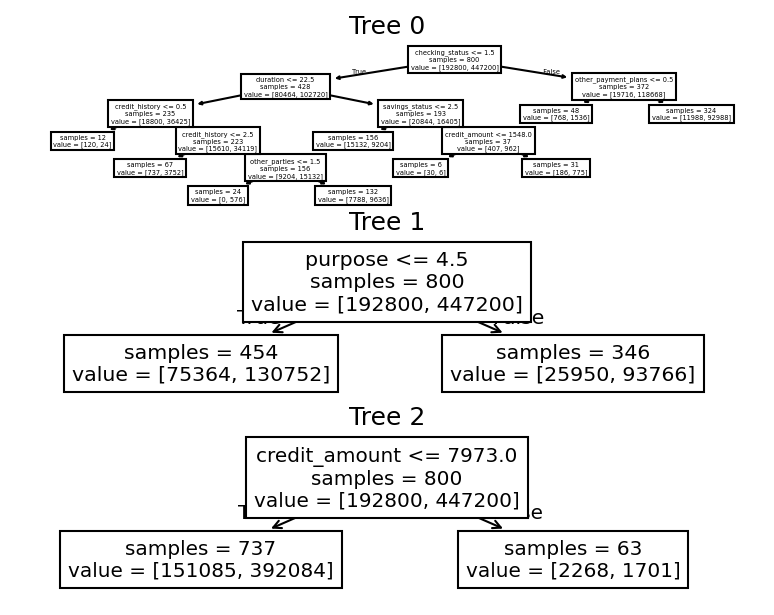

In [14]:
figs.plot()

The tree plot output seems nice but is ultimately somewhat confusing. The idea behind the FIGS tree is that you sum the value of each node as you transit through the tree for each data point. The output is passed through a sigmoid (threshold usually set to 0.5 similar to RuleFit) for a binary prediction. The values displayed in the tree here cannot be values for summation because they are too large and they are a list of two numbers. The text output is very informative, the plot is not so great.

### Now we will try Hierarchical Shrinkage

In [33]:
dt = HSTreeClassifier(max_leaf_nodes=10)
dt.fit(X_train, y_train)

preds = dt.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

Accuracy: 0.77


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


> We can see that FIGS and HSTree have similar accuracies (HS had a noticably shorter runtime even on this small dataset)

In [35]:
dt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


HSTreeClassifier(estimator_=DecisionTreeClassifier(max_leaf_nodes=10), reg_param=1, shrinkage_scheme_='node_based')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


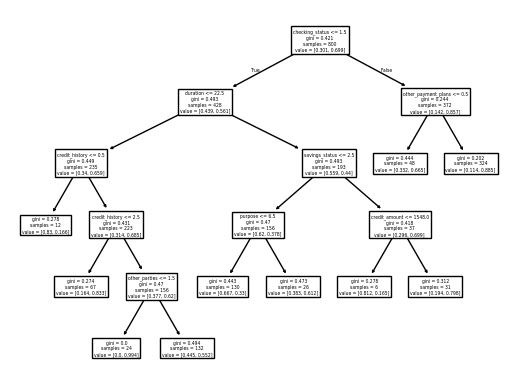

In [34]:
plot_tree(dt.estimator_,feature_names=feat_names)
plt.show()

> The output of HS Tree appears to be more complete and easy to follow. I can follow the logic and determining the class is simply the class determination at the leaf of the tree which is highly intuitive.

## Summary Comparison

RuleFit Classifier:

- Tree ensemble generated with gradient boosting. The trees are then used to form rules. The transition from one node to another is based on a rule. These rules are then put into a linear model with the original input features. This model utilizes LASSO regression which estimates the effects of each rule while also feature selecting. When no rule limit is set above the rule numbers that make it into the final output are clearly selected from a large list by LASSO regression.

- The output is a list of rules with an associated coefficient value and support value. The coefficient value is added to the prediction if the rule is true and the support value indicates how much of the data set a rule impacts. The top support value (1.00) seems to be a sort of bias term which sets an initial coefficent value to every data point. In our example the rule 'age' had a coefficient value of ~ +0.003. This rule applies to every data point since every person has an age. The positive coefficient seems to indicate a prior distribution weighted towards good credit and, indeed, we can see that there are more observations of that than bad credit.

In [37]:
y_train.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
class,
1,559
0,241


- This model is highly interpretable and, for any given data point, a human could easily follow the tree to get a prediction. The coefficient magnitude seems to indicate the strength of leverage against the prediction which is also an easy thing to cue in on as you observe the model outputs. This means that the model can easily be verified against domain expertise

Fast Interpretable Greedy-Tree Sums (FIGS):

- FIGS is similar to other decision tree algorithms but it appears to grow trees in competition simultaneously. At any stage FIGS may grow any existing tree it has already started or start a new tree, greedily selecting the option (or rule) which reduces the total unexplained variance.

- This model performs well at capturing complexities within the data as shown by its superior performance to RuleFit.

- The output is a nice decision tree (or really an ensemble of them) which can be utlized to predict the output. Each node's associated value is summed during transit and the final value is passed through a sigmoid. This makes it difficult for a human to manually compute the prediction for a given observation and slightly less intuitive to verify with domain expertise.

Hierarchical Shrinkage Trees:

- HS is not a tree-based method on its own but rather a post-hoc processing method for existing methods. It is not clear to me which tree-based method HSTree uses as its base in imodels. What it does is regularize the tree by shrinking the prediction over each node towards the sample means of its ancestors.

- The benefit of this method is that it can be used on top of any tree-based method to potentially increase performance. Its performance in this instance was identical to FIGS